                                МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ
                            НАЦІОНАЛЬНИЙ ТЕХНІЧНИЙ УНІВЕРСИТЕТ УКРАЇНИ
                                 “КИЇВСЬКИЙ ПОЛІТЕХНІЧНИЙ ІНСТИТУТ”
                                   Кафедра біомедичної кібернетики


                                        ПРАКТИЧНА РОБОТА 2

                                 з дисципліни «Нейронні мережі»
                                      «МЕТОДИ ОПТИМІЗАЦІЇ»
                                            Варіант 3


                                                                       Студента 3-го курсу
                                                                       групи БС-11
                                                                       Бутко В.Д.
                                             Київ 2023

### Поліном третього порядку: y = 2*x3 + 3*x2 + 2*x + 1 + noise

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [312]:
def timer(function):
    def wrapper(*args, **kwargs):

        start_time = time.time()
        result = function(*args, **kwargs)
        runtime = time.time() - start_time 
        
        # print('Runtime: ', runtime) # Comment for counting mean time
        
        return result, runtime

    return wrapper


### 1. Gradient descent

In [270]:
LR = 0.001
EPOCHS = 100000
ACCURACY = 1e-5
NUM_PARAMS = 4

In [271]:
np.random.seed(0)
X = np.linspace(-1, 1, 100)
noise = np.random.normal(0, 1, X.shape)
Y = 2*X**3 + 3*X**2 + 2*X + 1 + noise

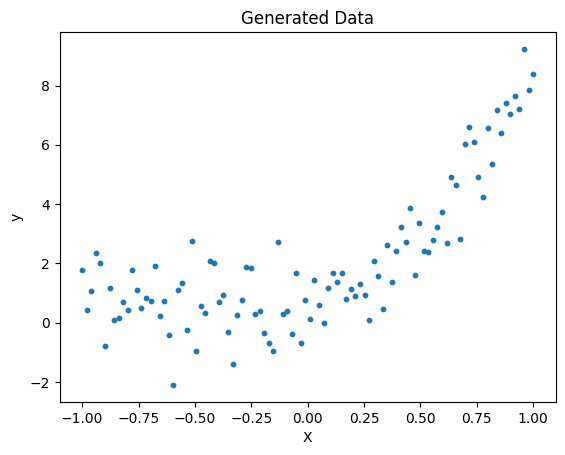

In [272]:
plt.scatter(X, Y, s=10)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated Data')
plt.show()

In [315]:
@timer
def gradient_descent(X, Y, params):
    prev_loss = np.inf  # Initialization of the previous value of the loss function with infinity

    
    for epoch in range(EPOCHS):
        y_pred = params[0]*X**3 + params[1]*X**2 + params[2]*X + params[3]
        
        error = y_pred - Y
        loss = np.mean(error ** 2) # MSE

        
        # If the change in the loss function is less than the specified threshold, we stop training
        if abs(prev_loss - loss) < ACCURACY:
            # print(f"Epoch stop {epoch}, Loss: {loss}") # Comment for counting mean time
            break
        
        gradients = np.array([
            np.mean(error * (X**3)) * 2,  # derivative by a
            np.mean(error * (X**2)) * 2,  # derivative by b
            np.mean(error * X) * 2,  # derivative by c
            np.mean(error) * 2  # derivative by d
        ])
        
        params -= LR * gradients
        
        prev_loss = loss  # Update the previous value of the loss function
        
        # if epoch % 1000 == 0:
        #     print(f"Epoch {epoch}, Loss: {loss}") # Comment for counting mean time
            
    return params, loss


In [295]:
params = np.random.randn(NUM_PARAMS) # I initialize all parameters outside the function for adaptability reasons. In this function format I can pass +- quite good parameters at once.
(params, loss), compute_time = gradient_descent(X, Y, params)

Epoch 0, Loss: 14.636045198030615
Epoch 1000, Loss: 3.3602554699426253
Epoch 2000, Loss: 1.7917878872775388
Epoch 3000, Loss: 1.4018274327232754
Epoch 4000, Loss: 1.2291803533536403
Epoch 5000, Loss: 1.121050153622238
Epoch 6000, Loss: 1.0456215610215314
Epoch 7000, Loss: 0.9916768749108644
Epoch 8000, Loss: 0.952890964383331
Epoch 9000, Loss: 0.9249724592725528
Epoch 10000, Loss: 0.9048711246360901
Epoch 11000, Loss: 0.8903968477595234
Epoch stop 11614, Loss: 0.8835974523917368
Runtime:  0.36026501655578613


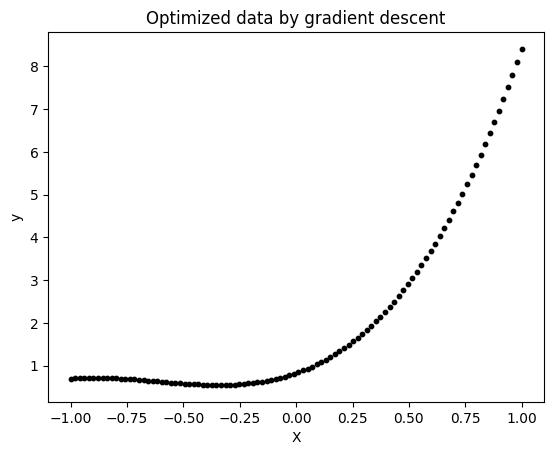

In [296]:
y = params[0]*X**3 + params[1]*X**2 + params[2]*X + params[3]
plt.scatter(X, y, s=10, c='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Optimized data by gradient descent')
plt.show()

### 2. Hill Climbing

In [278]:
STEP = 0.1
EPOCHS = 100000
ACCURACY = 1e-5
NUM_PARAMS = 4

In [314]:
@timer
def hill_climbing(X, Y, params):

    best_loss = np.inf
    prev_loss = np.inf
    best_params = None
    

    for epoch in range(EPOCHS):
        # Random variation of parameters
        new_params = params + (np.random.rand(4) - 0.5) * STEP

        # Calculation of the loss function with new parameters
        y_pred = new_params[0]*X**3 + new_params[1]*X**2 + new_params[2]*X + new_params[3]
        loss = np.mean((Y - y_pred) ** 2)
        

        # If the new loss is smaller, we keep the new parameters as the best ones
        if loss < best_loss:
            
            best_params = new_params
            params = new_params
            prev_loss = best_loss 
            best_loss = loss
            
            # If the change in the loss function is less than the specified threshold, we stop training
            if abs(prev_loss - best_loss) < ACCURACY:
                # print(f"Epoch stop {epoch}, Loss: {best_loss}") # Comment for counting mean time
                break

        
        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch}, Loss: {loss}") # Comment for counting mean time

    return best_params, best_loss





In [298]:
epochs = 100000
accuracy = 1e-5
step = 0.1
params = np.random.randn(NUM_PARAMS)

(params, loss), compute_time = hill_climbing(X, Y, params)


Epoch 0, Loss: 4.65835644559719
Epoch 100, Loss: 2.2296988797259845
Epoch 200, Loss: 1.3716869930938365
Epoch 300, Loss: 1.0217233517840527
Epoch 400, Loss: 0.8868316150564836
Epoch 500, Loss: 0.8631626374869583
Epoch 600, Loss: 0.8549660480335689
Epoch 700, Loss: 0.8545614882980815
Epoch stop 714, Loss: 0.8533390511389204
Runtime:  0.014686822891235352


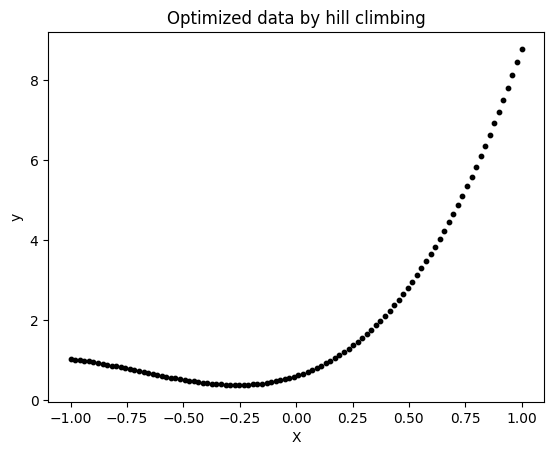

In [301]:
y = params[0]*X**3 + params[1]*X**2 + params[2]*X + params[3]
plt.scatter(X, y, s=10, c='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Optimized data by hill climbing')
plt.show()

### 3. Генетичний алгоритм

In [306]:
POPULATION_SIZE = 100
MUTATION_RATE = 0.1
NUM_PARAMS = 4
EPOCHS = 100000
TOURNAMENT_SIZE = 3
ACCURACY = 1e-5

In [322]:
# Function to calculate the fitness of an individual in the population
def fitness(individ, X, Y):
    pred = individ[0]*X**3 + individ[1]*X**2 + individ[2]*X + individ[3]
    fitness = np.mean((Y - pred) ** 2)
    return fitness

# Function to perform tournament selection from the population.
def tounament(population, fitness):
    # Randomly selecting tournament participants.
    participants = np.random.choice(np.arange(POPULATION_SIZE), size=TOURNAMENT_SIZE, replace=False)
    # The winner is the one with the lowest fitness
    winners = participants[np.argmin(fitness[participants])]
    
    return population[winners]

# Function to perform crossover between two parents.
def crossover(parent1, parent2):
    point = np.random.randint(1, NUM_PARAMS)
    child = np.concatenate((parent1[:point], parent2[point:]))
    
    return child

# Function to perform mutation on an individual.
def mutate(individ):
    if np.random.rand() < MUTATION_RATE:
        # Adding random noise to a randomly selected parameter.
        individ[np.random.randint(0, NUM_PARAMS)] += np.random.randn()
    
    return individ

# Main function of the genetic algorithm.
@timer
def genetic(X, Y, population):
    
    best_individual = None
    best_fitness = np.inf
    
    for epoch in range(EPOCHS):
        
        fitness_scores = np.array([fitness(individ, X, Y) for individ in population])
        
        new_population = []
        
        # Creating new individuals for the next generation.
        for _ in range(POPULATION_SIZE // 2):
            
            parent1, parent2 = tounament(population, fitness_scores), tounament(population, fitness_scores)
            
            child1, child2 = crossover(parent1, parent2), crossover(parent1, parent2)
            child1, child2 = mutate(child1), mutate(child2)

                
            new_population.extend([child1, child2])
            
        population = np.array(new_population)
        
        # Evaluating the new population
        fitness_scores = np.array([fitness(individ, X, Y) for individ in population])
        
        min_fitness_index = np.argmin(fitness_scores)
        min_fitness = fitness_scores[min_fitness_index]
        
        # If we have found a new best individual, update best_fitness and best_individual.
        if min_fitness < best_fitness:
            fitness_improvement = best_fitness - min_fitness
            best_fitness = min_fitness
            best_individual = population[min_fitness_index]


            # Stopping criterion based on the improvement of fitness.
            if fitness_improvement < ACCURACY:
                # print(f"Epoch stop {epoch}, Loss: {best_fitness}") # Comment for counting mean time
                break
            
        # if epoch % 10 == 0: 
        #     print(f'Epoch {epoch}, Loss: {best_fitness}') # Comment for counting mean time
            
    return best_individual, best_fitness

In [309]:
population = np.random.randn(POPULATION_SIZE, NUM_PARAMS)
(param, loss), compute_time = genetic(X, Y, population)

Epoch 0, Loss: 1.2694881440164618
Epoch 10, Loss: 0.8681658277039515
Epoch 20, Loss: 0.8570847028046582
Epoch 30, Loss: 0.8570847028046582
Epoch 40, Loss: 0.8570847028046582
Epoch 50, Loss: 0.8561040215614959
Epoch 60, Loss: 0.8561040215614959
Epoch 70, Loss: 0.8561040215614959
Epoch 80, Loss: 0.8561040215614959
Epoch 90, Loss: 0.8545038943908712
Epoch 100, Loss: 0.8544751605055761
Epoch 110, Loss: 0.8541181561473761
Epoch 120, Loss: 0.8540285763942805
Epoch 130, Loss: 0.8539833872857492
Epoch 140, Loss: 0.8535257913624202
Epoch 150, Loss: 0.8535257913624202
Epoch 160, Loss: 0.8535043276685598
Epoch stop 170, Loss: 0.8535036105713302
Runtime:  0.5951910018920898


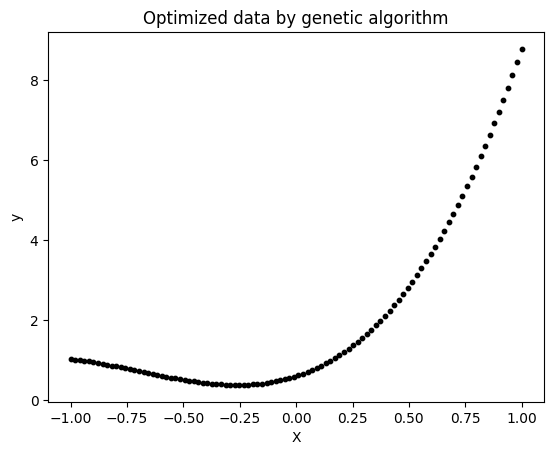

In [310]:
y = params[0]*X**3 + params[1]*X**2 + params[2]*X + params[3]
plt.scatter(X, y, s=10, c='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Optimized data by genetic algorithm')
plt.show()

In [326]:
gradient = {'time':[],
            'loss':[]}
hill_climb = {'time':[],
            'loss':[]}
genetic_ = {'time':[],
            'loss':[]}


for _ in range(200):
    params = np.random.randn(NUM_PARAMS) 
    (params, loss), compute_time = gradient_descent(X, Y, params)
    gradient['time'].append(compute_time)
    gradient['loss'].append(loss)
    
    params = np.random.randn(NUM_PARAMS) 
    (params, loss), compute_time = hill_climbing(X, Y, params)
    hill_climb['time'].append(compute_time)
    hill_climb['loss'].append(loss)
    
    population = np.random.randn(POPULATION_SIZE, NUM_PARAMS)
    (param, loss), compute_time = genetic(X, Y, population)
    genetic_['time'].append(compute_time)
    genetic_['loss'].append(loss)

In [327]:
import pandas as pd

df = pd.DataFrame({'Gradient descent' : [np.mean(gradient['time']), np.mean(gradient['loss'])],
                   'Hill climbing' : [np.mean(hill_climb['time']), np.mean(hill_climb['loss'])],
                   'Genetic' : [np.mean(genetic_['time']), np.mean(genetic_['loss'])]}, index=['time', 'loss'])

df

,Gradient descent,Hill climbing,Genetic
time,0.197859,0.029203,0.344606
loss,0.892416,0.929456,0.859242


Насправді я не бачу сенсу в порівнянні кількості ітерацій, адже зрозуміло, що в генетичному алгоритмі ітерація важить набагато більше ніж в hill climbing. Для мене найбільш показовими є час та похибка. Я порахував середні значення цих показників на 200 ітераціях кожного алгоритму. У результаті бачимо, що генетичний алгоритм впорався найкраще, проте більше ніж в 10 разів довше ніж hill climbing, та у 1.7 разів довше ніж градієнтний спуск. Для багатьох задач він стає бажаним вибором завдяки точності. Hill climbing неймовірно швидкий завдяки своій простоті, але найменш точний. Градієнтний спуск - середняк у всьому. Будемо відверті, функція для оптимізації була вкрай простою, тому hill climbing впорався, для більш складних випадків - він буде мало корисним. Градієнтний спуск бе модификацій теж застрягне на першому локальному мінімумі. Тому серед даних виконань цих алгоритмів я віддам перевагу генетичному.  

## Контрольні питання

1. Градієнтний спуск - це оптимізаційний алгоритм, який використовується для мінімізації функції витрат (або помилок) шляхом ітеративного руху в напрямку, що зменшує цю функцію. Цей метод широко застосовується в різних областях, особливо в машинному навчанні, для тренування моделей шляхом корекції параметрів. Градієнтний спуск важливий, оскільки він пропонує ефективний метод для вдосконалення моделей машинного навчання, автоматично визначаючи оптимальні параметри, що мінімізують помилки прогнозування. Це особливо корисно в складних системах, де вручну налаштування параметрів є непрактичним або неможливим.

2. 
 - Цільова функція (Функція витрат або Функція помилок): Це функція, яку необхідно оптимізувати, зазвичай шляхом мінімізації. У контексті машинного навчання, цільова функція часто вимірює "помилку" або "втрату" моделі, тобто різницю між прогнозами моделі та дійсними значеннями.

 - Градієнт: Градієнт цільової функції визначає напрямок найшвидшого зростання функції. Він складається з часткових похідних функції відносно її параметрів. У градієнтному спуску ми рухаємося у напрямку, протилежному градієнту, щоб знайти мінімум функції.

 - Швидкість навчання (learning rate): Це гіперпараметр, який контролює, наскільки далеко ми рухаємося вздовж градієнта під час кожного кроку. Занадто велика швидкість може призвести до "перестрибування" мінімуму, а занадто мала - до надмірно повільної конвергенції або навіть зупинки процесу оптимізації.

 - Оновлення параметрів: На основі обчисленого градієнта та швидкості навчання параметри моделі (наприклад, ваги) оновлюються таким чином, щоб зменшити значення цільової функції. Цей крок повторюється ітеративно до досягнення критеріїв зупинки (наприклад, до тих пір, поки зміни в цільовій функції не стануть незначними).

 - Умови зупинки: Це критерії, які визначають, коли процес оптимізації слід зупинити. Це може бути певна кількість ітерацій, досягнення певного рівня помилки або стабілізація параметрів моделі.

3. Швидкість навчання, також відома як "крок навчання", у контексті градієнтного спуску є одним з найважливіших гіперпараметрів, який контролює, наскільки далеко модель "крокує" у напрямку градієнта на кожній ітерації оптимізації. Це числове значення визначає, наскільки сильно оновлюються параметри моделі, такі як ваги, під час одного кроку тренування.

    Вплив швидкості навчання на процес оптимізації:

 - Занадто висока швидкість навчання: Якщо швидкість навчання занадто велика, процес тренування може стати нестабільним, оскільки великі кроки можуть призвести до "перестрибування" через мінімум функції витрат. Це може призвести до того, що алгоритм ніколи не збігається або, що ще гірше, веде до зростання помилок через надмірні коливання в значеннях параметрів.

 - Занадто низька швидкість навчання: З іншого боку, дуже мала швидкість навчання може призвести до того, що процес тренування буде надзвичайно повільним, оскільки модель робить лише невеликі зміни в параметрах на кожному кроці. Це також може призвести до передчасної конвергенції в локальний мінімум, який не є оптимальним рішенням.

 - Оптимальна швидкість навчання: Вибір правильної швидкості навчання може допомогти алгоритму швидко збігтися до глобального мінімуму функції витрат. Оптимальна швидкість навчання дозволяє моделі ефективно оновлювати параметри без ризику втрати стабільності або застрягання в неефективних точках.

4. Градієнтний спуск впорядковує параметри моделі шляхом ітеративного оновлення їх значень з метою мінімізації функції витрат (або функції помилок). Ось як цей процес працює крок за кроком:

 - Ініціалізація параметрів: Перед початком процесу оптимізації параметри моделі (наприклад, ваги в нейронній мережі) ініціалізуються випадковим чином або за допомогою певної стратегії. Це стартова точка для оптимізації.

 - Обчислення градієнта: Для кожного параметра моделі обчислюється градієнт функції витрат. Градієнт вказує, як функція витрат зміниться з невеликою зміною параметра. Він вказує напрямок, в якому функція витрат зростає найшвидше.

 - Оновлення параметрів: Параметри моделі потім оновлюються в напрямку, протилежному градієнту. Це робиться для того, щоб "крокувати" в напрямку, де функція витрат зменшується (тобто в напрямку мінімуму). Оновлення виконується за формулою: нове значення параметра = старе значення параметра - швидкість навчання * градієнт.

 - Ітерація: Ці кроки повторюються для кожної ітерації тренування (або "епохи"), кожного разу оновлюючи параметри моделі так, щоб зменшити функцію витрат.

 - Перевірка збіжності: Процес триває до тих пір, поки не буде досягнуто критеріїв зупинки, які можуть включати мінімальні зміни в функції витрат, досягнення певної кількості ітерацій або інші умови, які вказують на те, що модель оптимізована.

Ключовим аспектом цього процесу є те, що градієнтний спуск використовує інформацію з градієнтів для того, щоб "навчати" параметри моделі, коригуючи їх таким чином, щоб мінімізувати помилки, які модель робить на тренувальних даних. Це допомагає моделі стати більш точною в прогнозуванні або класифікації нових даних.







5. Градієнтний спуск є популярним методом оптимізації, особливо в машинному навчанні, завдяки своїй ефективності, універсальності, простоті імплементації та адаптивності. Цей метод ефективно працює з великими датасетами, оновлюючи параметри моделі за допомогою градієнтів, що робить його швидким і масштабованим. Його універсальність полягає в тому, що він може бути застосований до широкого спектра функцій витрат. Простота імплементації робить градієнтний спуск доступним для широкого кола розробників, а адаптивність виявляється в здатності методу автоматично налаштовувати швидкість навчання, що полегшує оптимізацію. Крім того, градієнтний спуск добре зарекомендував себе, демонструючи ефективність у різних застосуваннях, від простих задач регресії до складних нейронних мереж. Ці характеристики роблять градієнтний спуск центральним елементом в багатьох стратегіях машинного навчання і штучного інтелекту.

6. Метод "Hill Climbing" (або "Верхове лазіння") є простим ітеративним алгоритмом, який використовується для вирішення задач оптимізації. Цей метод спрямований на знаходження оптимального рішення шляхом "лазіння вгору" через простір рішень, роблячи невеликі зміни в поточному рішенні і приймаючи ці зміни, якщо вони призводять до покращення цільової функції.

Ключові відмінності між методом Hill Climbing і градієнтним спуском:

 - Напрямок оптимізації: Hill Climbing зазвичай використовується для максимізації функції, тобто шукає "вершину" або локальний максимум. Градієнтний спуск, з іншого боку, зазвичай використовується для мінімізації функції, рухаючись у напрямку найшвидшого спаду (або "спускаючись" до мінімуму).

 - Використання градієнтів: Градієнтний спуск використовує градієнти (або часткові похідні) функції для визначення напрямку, в якому слід рухатися. Hill Climbing не вимагає обчислення градієнтів; замість цього, він робить невеликі зміни в рішенні і оцінює, чи призводять ці зміни до покращення.

 - Стратегія змін: Hill Climbing робить невеликі випадкові зміни в стані або рішенні і приймає їх, якщо це покращує цільову функцію. Градієнтний спуск робить більш структуровані зміни, використовуючи градієнт для визначення оптимального кроку для оновлення параметрів.

 - Локальні мінімуми та максимуми: Hill Climbing схильний до застрягання в локальних максимумах, оскільки він не має механізму для "виходу" з них. Градієнтний спуск також може застрягати в локальних мінімумах, але існують різні варіації та стратегії, які допомагають уникнути цього.

 - Складність і застосування: Hill Climbing є більш простим у реалізації, але може бути не таким ефективним для складних просторів пошуку або функцій з багатьма локальними максимумами. Градієнтний спуск вимагає більше обчислень, але зазвичай є більш ефективним для оптимізації складних моделей, таких як нейронні мережі.

7. Метод Hill Climbing працює за принципом, що починається з випадково обраної точки у просторі можливих рішень. Далі, система визначає сусідню точку і зіставляє значення цільової функції в цій новій точці з поточним значенням. Якщо нове значення виявляється кращим (тобто більшим при максимізації або меншим при мінімізації), то рух відбувається до цієї нової точки. Ця процедура повторюється до тих пір, поки не буде знайдено максимум або не буде досягнуто заданої кількості ітерацій.

8. Генетичний алгоритм - це метод оптимізації, який наслідує процес природного відбору, який лежить в основі еволюційної теорії Дарвіна. Ці алгоритми використовують механізми, подібні до генетичної спадковості та природного відбору, з метою знаходження оптимальних рішень для складних задач.

    Базовий принцип роботи генетичного алгоритму:

a. Ініціалізація популяції: Спочатку створюється популяція випадкових кандидатних рішень (індивідів), як правило, у вигляді хромосом або рядків коду, які представляють різні рішення.

b. Оцінка здатності: Кожне рішення (індивід) оцінюється на основі функції здатності (fitness function), яка вимірює, наскільки добре індивід вирішує поставлену задачу.

c. Селекція: Індивіди вибираються для створення нового покоління. Індивіди з вищим рівнем здатності мають більше шансів бути вибраними. Цей процес імітує виживання найпридатніших у природному відборі.

d. Кросинговер (схрещування): Вибрані індивіди комбінуються між собою, щоб створити нове покоління рішень. Це може включати обмін частинами їхніх хромосом (кодів) і спрямоване на комбінування хороших рис батьківських індивідів у нащадках.

e. Мутація: Для збереження генетичного різноманіття в популяції випадковим чином вносяться невеликі зміни в окремі нові індивіди. Це допомагає алгоритму уникнути застрягання в локальних оптимумах шляхом дослідження нових областей простору рішень.

f. Нове покоління та ітерація: Нове покоління індивідів замінює старе, і процес повторюється з оцінки здатності. Ці кроки ітеративно повторюються протягом багатьох поколінь.

Генетичний алгоритм продовжує цикл оцінки, селекції, схрещування та мутації, поки не буде досягнуто критерію зупинки, наприклад, певного числа поколінь, стабільності популяції або задовільного рівня здатності. Цей метод є потужним для вирішення складних та багатовимірних задач, де традиційні методи оптимізації можуть бути неефективними.

9. Неградієнтні методи оптимізації виявляються особливо корисними у випадках, коли функції цілі є недиференційованими, мають багато локальних оптимумів або коли простір пошуку має високу розмірність. Градієнтні методи залежать від наявності неперервних похідних, що може бути обмежуючим фактором для складних або нерегулярних функцій. Неградієнтні методи, з іншого боку, не вимагають похідних і можуть ефективно навігувати в просторах з багатьма локальними оптимумами, де градієнтні методи можуть застрягати. Крім того, вони можуть бути більш ефективними в областях з великою розмірністю, де градієнтні методи можуть виявитися обчислювально непридатними через необхідність обчислення градієнтів. Таким чином, неградієнтні методи пропонують гнучкість та робастність, особливо в складних областях оптимізації.

10. Обрати метод оптимізації для певної задачі - це процес, який вимагає уважного аналізу характеристик задачі та специфічних вимог до рішення. Як я казав раніше, деякі задачі краще підходять для неградієнтних методів оптимізації через свою структуру. Наприклад, якщо функція цілі недиференційована, має багато локальних оптимумів, або коли простір пошуку має високу розмірність, неградієнтні методи, такі як генетичні алгоритми, можуть ефективно обходити ці складнощі, не потребуючи похідних і здатні досліджувати ширший простір пошуку.

    При виборі методу оптимізації важливо також враховувати обчислювальні ресурси, оскільки деякі методи можуть бути вимогливими до обчислень. Точність та швидкість збіжності також є критичними факторами, особливо в умовах обмеженого часу або ресурсів. Крім того, специфіка задачі, включаючи будь-які унікальні обмеження або вимоги, може вимагати певного підходу до оптимізації. Враховуючи всі ці аспекти, можна вибрати оптимальний метод для конкретної ситуації, забезпечуючи ефективність та адекватність рішення.